In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import h5py

from HelperAndMechanics import *

In [2]:
N = 3000
# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta05l.h5', 'r') as f:
    x_temp = f['x_temp'][:]
    x_cm_temp = f['x_cm_temp'][:]
    T = f['T'][:]
    dA = f['dA'][:]
    f.close()


In [164]:
t_start,t_stop = 0,4500
i,j = 50,50

T_train = T[t_start:t_stop,i,j]
dA_test = dA[t_stop+500:,i,j]
T_test = T[t_stop+500:,i,j]
x_arr_train_raw = np.array([x_temp[t_start:t_stop,:,i,j],x_temp[t_start:t_stop,:,i,j+1],x_temp[t_start:t_stop,:,i+1,j+1],x_temp[t_start:t_stop,:,i+1,j]])

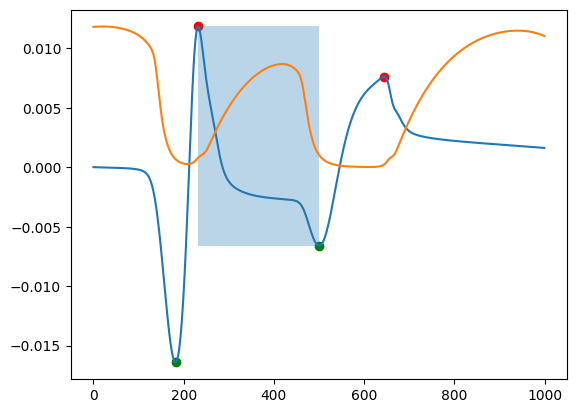

In [165]:
maxima_temp0, _ = find_peaks(dA_test,prominence=.0007)#,height=.001
minima_temp0, _ = find_peaks(-dA_test,prominence=.0007)#,height=.001

max_indx, min_indx = index_finder(maxima_temp0, minima_temp0, dA_test,start_indx=0)

plt.plot(dA_test)
plt.scatter(maxima_temp0,dA_test[maxima_temp0],c='r')
plt.scatter(minima_temp0,dA_test[minima_temp0],c='g')
#create a transparent space maxima_temp0[max_indx],minima_temp0[min_indx] on the x axis
plt.fill_between([maxima_temp0[max_indx],minima_temp0[min_indx]],dA_test[minima_temp0[min_indx]],dA_test[maxima_temp0[max_indx]],alpha=.3)
plt.plot(T_test/np.max(T_test)*np.max(dA_test))
t_start_test = maxima_temp0[max_indx]-200
t_stop_test = minima_temp0[min_indx]+100

In [166]:
T_test = T[t_start_test:t_stop_test,i,j]
x_arr_test_raw = np.array([x_temp[t_start_test:t_stop_test,:,i,j],x_temp[t_start_test:t_stop_test,:,i,j+1],x_temp[t_start_test:t_stop_test,:,i+1,j+1],x_temp[t_start_test:t_stop_test,:,i+1,j]])

delta_t = 2
number_of_comp = 50 
x_arr_train = np.swapaxes(x_arr_train_raw,1,2)
x_arr_train_flattened_raw = x_arr_train.reshape(8, 1, -1)             
x_arr_train_flattened = x_arr_train_flattened_raw

x_arr_test = np.swapaxes(x_arr_test_raw,1,2)
x_arr_test_flattened_raw = x_arr_test.reshape(8, 1, -1)          
x_arr_test_flattened = x_arr_test_flattened_raw

#np.roll x_arr_train_flattened along axis 2 by delta_t
for shift in range(-int(number_of_comp/2),int(number_of_comp/2)+1):
    if shift == 0:
        continue
    else:
        x_arr_train_flattened_shifted = np.roll(x_arr_train_flattened_raw,shift * delta_t, axis=2)
        x_arr_test_flattened_shifted = np.roll(x_arr_test_flattened_raw,shift * delta_t, axis=2)
        #add to X_arr_train_flattened along axis 1
        x_arr_train_flattened = np.concatenate((x_arr_train_flattened,x_arr_train_flattened_shifted),axis=1)
        x_arr_test_flattened = np.concatenate((x_arr_test_flattened,x_arr_test_flattened_shifted),axis=1)

time_indices = []

for current_index in range(delta_t,x_arr_test_flattened.shape[-1]-delta_t):
    x_current = x_arr_test_flattened[:,:,current_index]
    x_current_broadcasted = x_current.reshape(x_current.shape[0], x_current.shape[1], 1) 
    squared_differences = (x_arr_train_flattened - x_current_broadcasted) ** 2
    sum_squared_differences = np.sum(squared_differences, axis=0)   # Shape: (1, len_t)
    sum_squared_differences = np.sum(sum_squared_differences, axis=0)   # Shape: (1, len_t)
    euclidean_distances = np.sqrt(np.squeeze(sum_squared_differences))  # Shape: (len_t,)print('shape (len_t,)',euclidean_distances.shape)
    
    # Find the overall minimum distance and its index in the time series
    overall_min_distance = np.min(euclidean_distances)              # Minimum Euclidean distance
    overall_min_flat_index = np.argmin(euclidean_distances)              # Time index where minimum occurs

    time_indices.append(overall_min_flat_index)
    

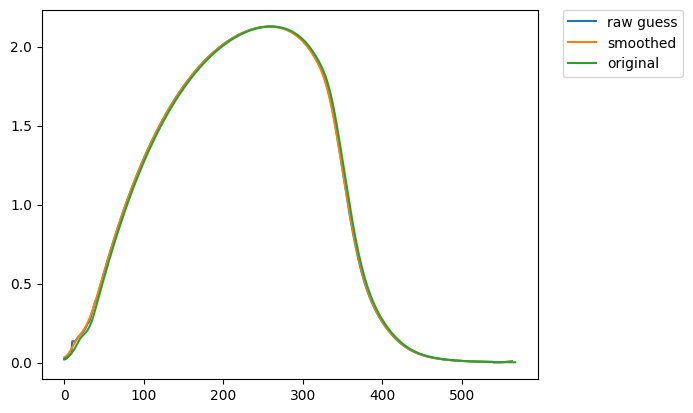

In [167]:
#apply gaussian smoothing to T_train
from scipy.ndimage import gaussian_filter1d
T_train_smoothed = gaussian_filter1d(T_train[time_indices], sigma=5)

plt.plot(T_train[time_indices], label='raw guess')
plt.plot(T_train_smoothed, label='smoothed')
plt.plot(T_test, label='original')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)